In [ ]:
!pip install pandas numpy matplotlib scipy PyWavelets scikit-learn joblib lightgbm openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.8 MB/s eta 0:00:00


Giải nén file ZIP vào thư mục tạm: /tmp/tmpj7o_qnap
Nội dung file ZIP:
Wind Turbine Blades Fault Diagnosis based on Vibration Dataset Analysis/Vibration dataset vs. wind speed/crack fault state-Vw=4.5.csv
Wind Turbine Blades Fault Diagnosis based on Vibration Dataset Analysis/Vibration dataset vs. wind speed/crack fault-Vw=4.csv
Wind Turbine Blades Fault Diagnosis based on Vibration Dataset Analysis/Vibration dataset vs. wind speed/Crack Fault-Vw=5.csv
Wind Turbine Blades Fault Diagnosis based on Vibration Dataset Analysis/Vibration dataset vs. wind speed/Crack State-Vw=1.3.csv
Wind Turbine Blades Fault Diagnosis based on Vibration Dataset Analysis/Vibration dataset vs. wind speed/Crack state-Vw=3.3.csv
Wind Turbine Blades Fault Diagnosis based on Vibration Dataset Analysis/Vibration dataset vs. wind speed/Crack Fault-Vw=5.4.csv
Wind Turbine Blades Fault Diagnosis based on Vibration Dataset Analysis/Vibration dataset vs. wind speed/Crack state-Vw=2.8.csv
Wind Turbine Blades Fault Diagn

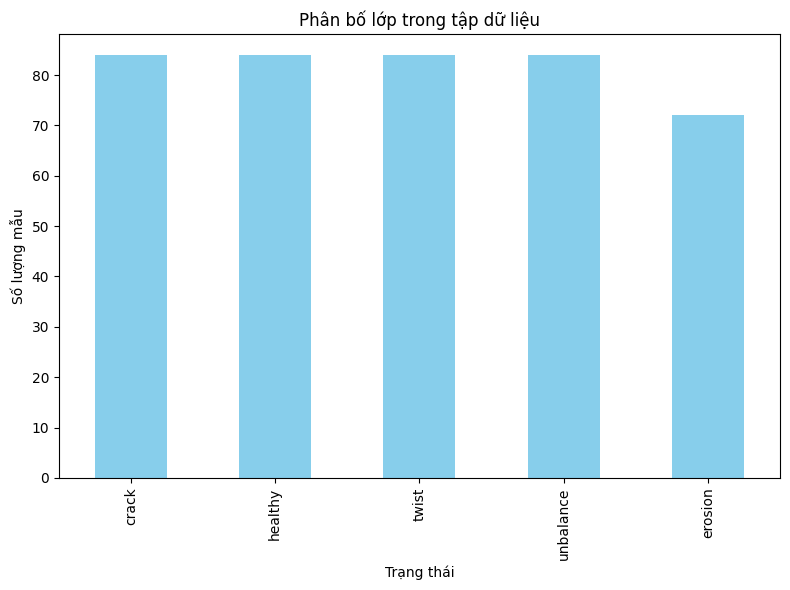

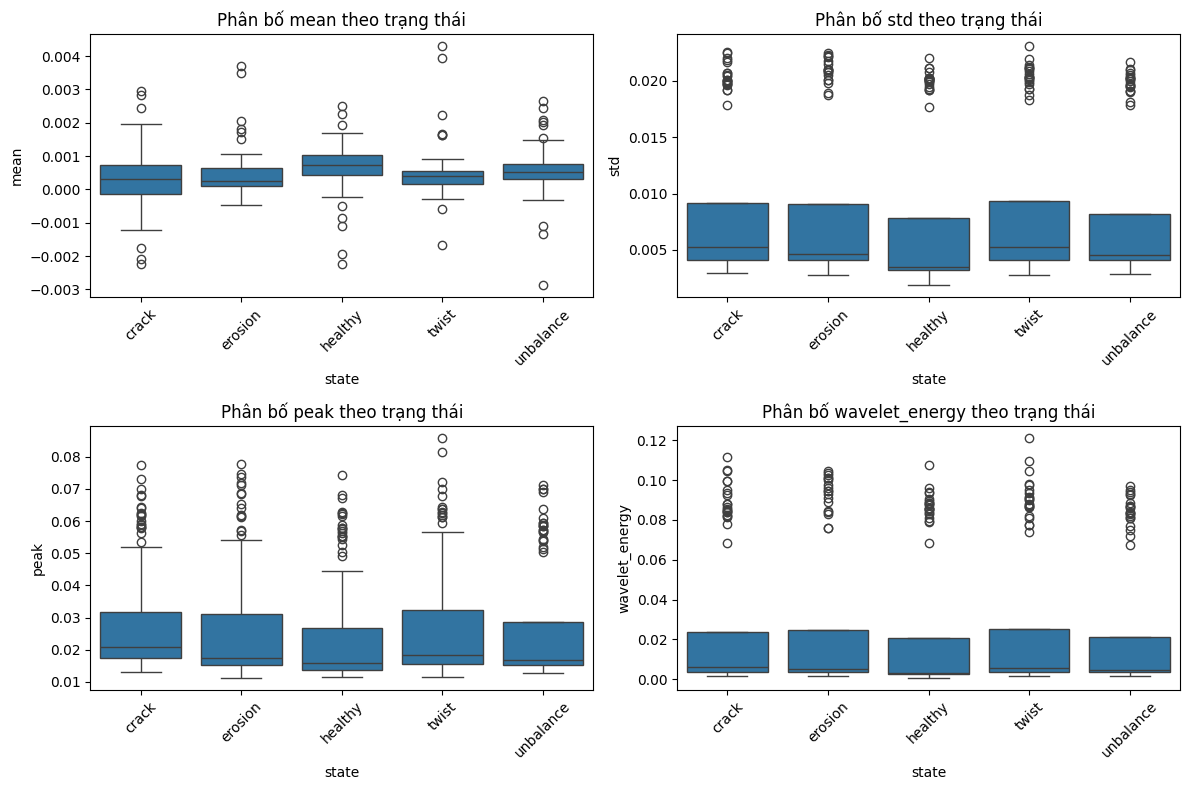

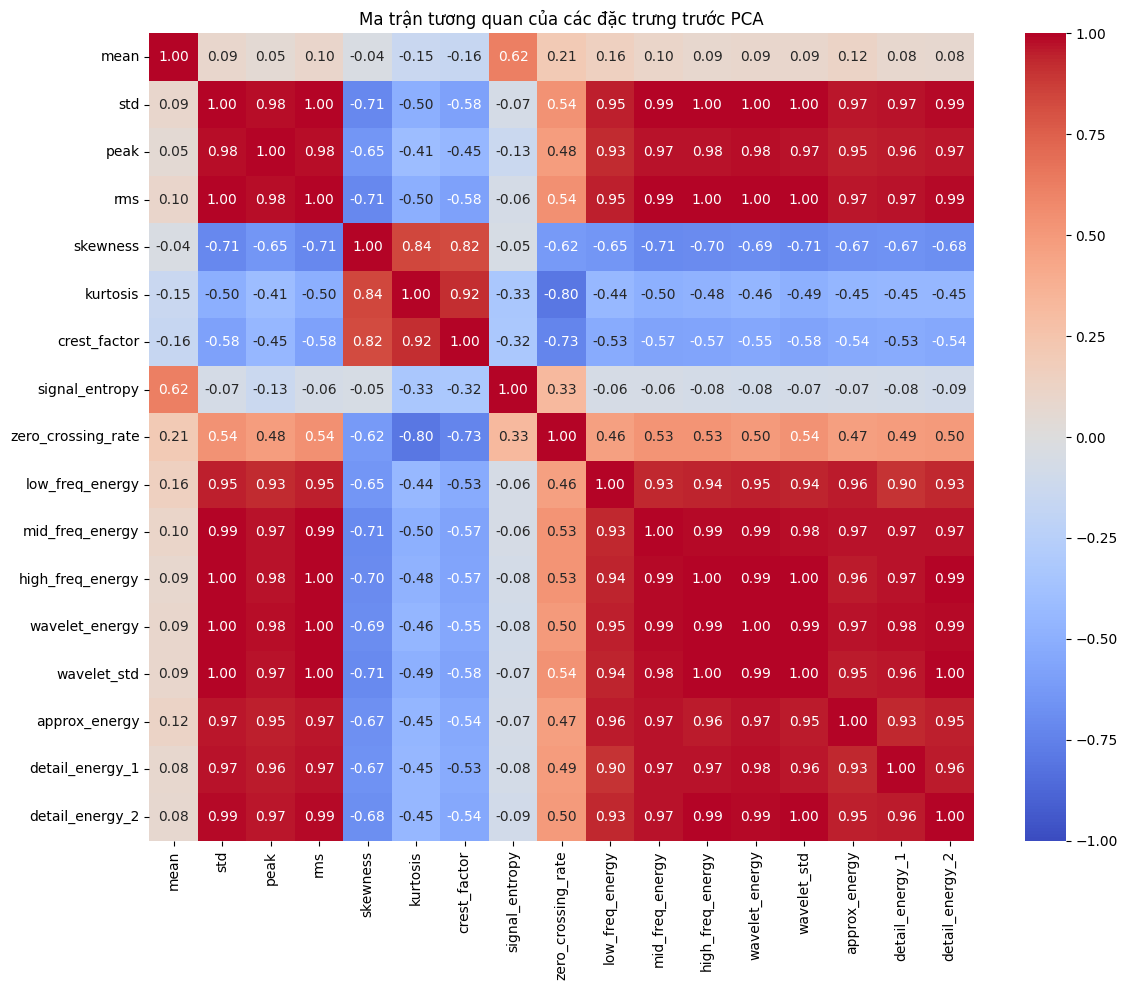

Đã giảm chiều từ 17 xuống 8 đặc trưng với PCA.
Tỷ lệ phương sai được giải thích: 0.9932


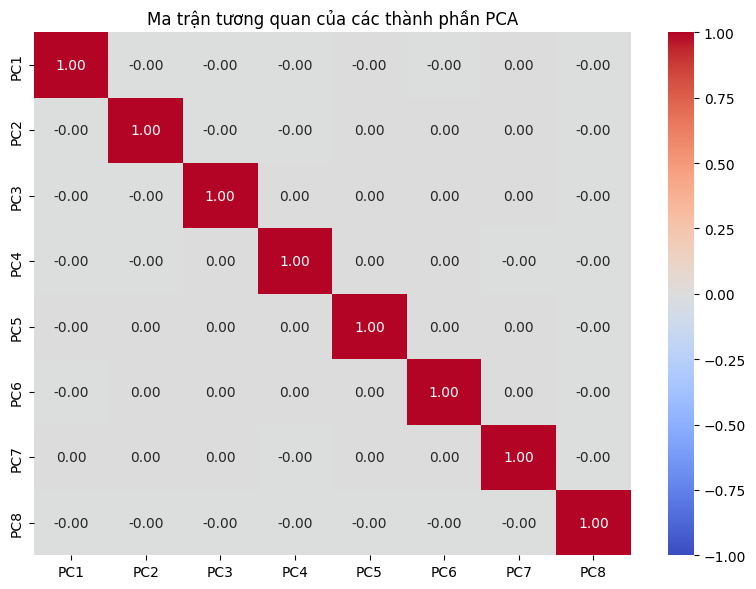

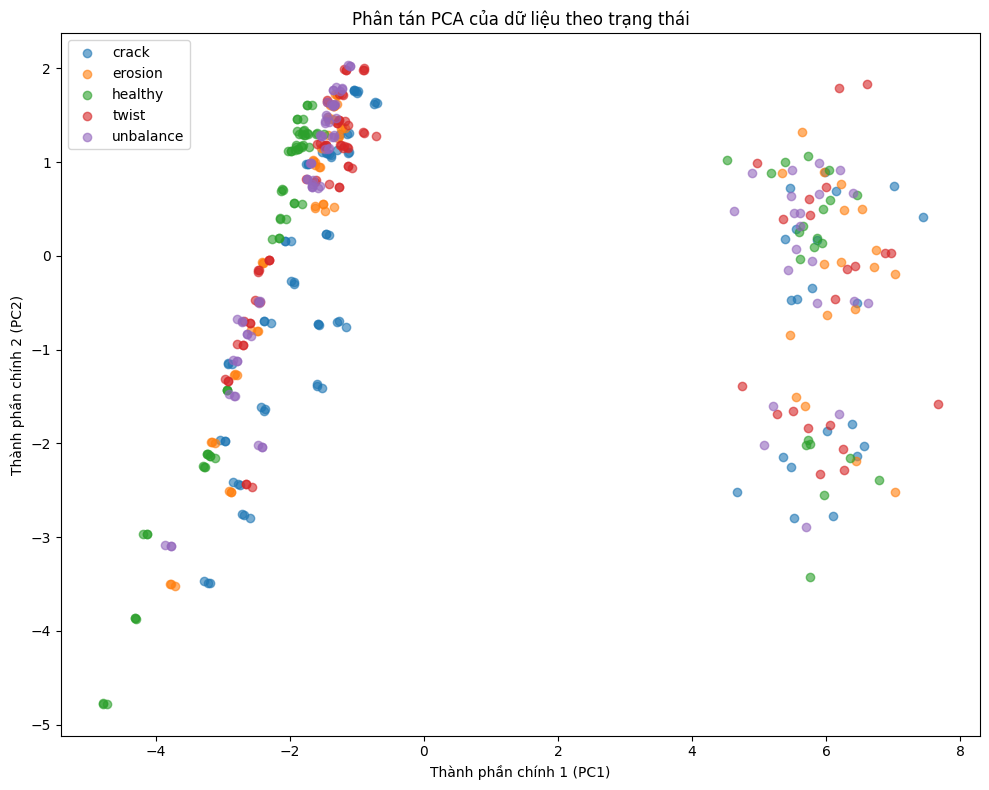

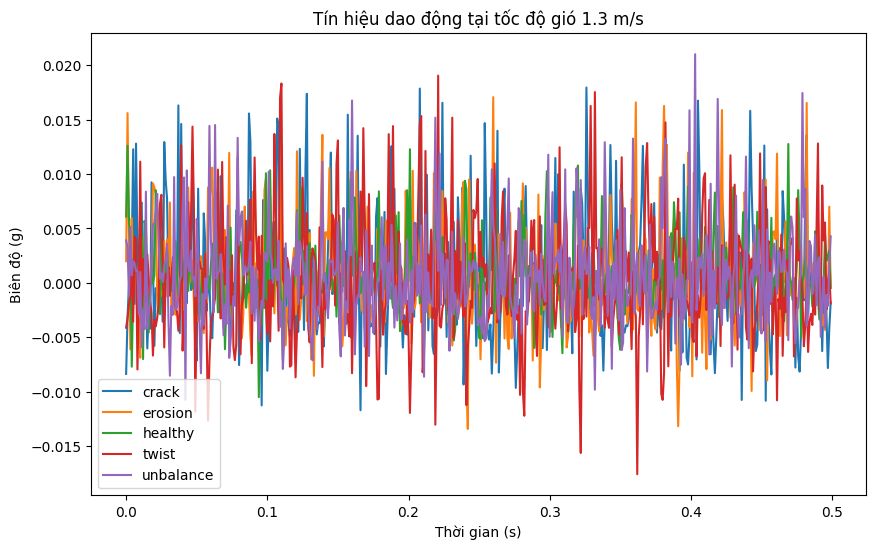

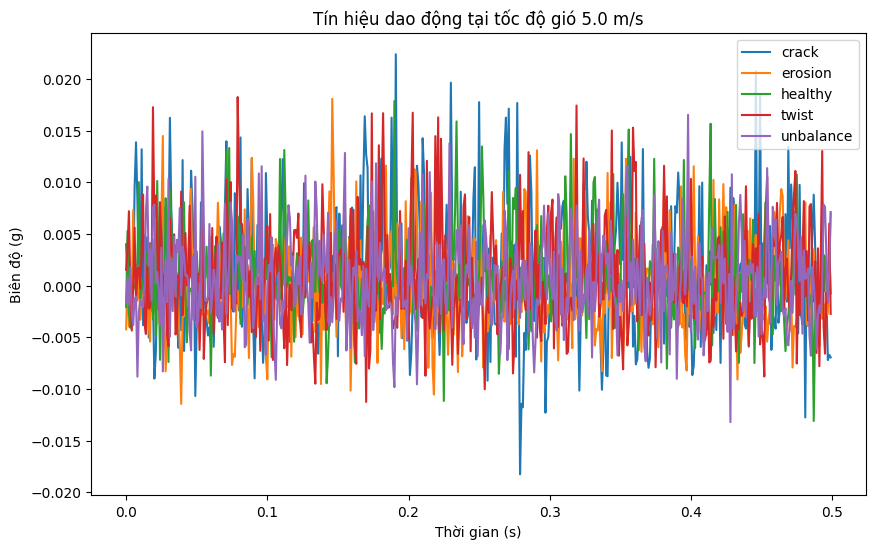


Đang huấn luyện mô hình: LightGBM
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


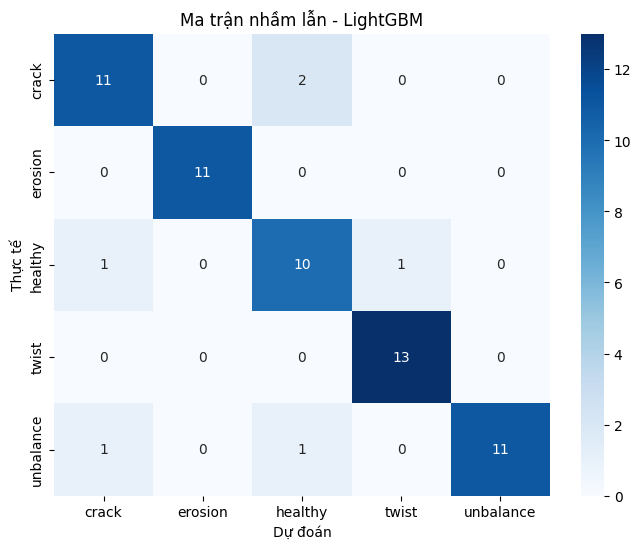

Điểm kiểm tra chéo tốt nhất (LightGBM): 0.7199
Tham số tốt nhất (LightGBM): {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 15, 'subsample': 0.8}
Báo cáo phân loại (LightGBM):
               precision    recall  f1-score   support

       crack       0.85      0.85      0.85        13
     erosion       1.00      1.00      1.00        11
     healthy       0.77      0.83      0.80        12
       twist       0.93      1.00      0.96        13
   unbalance       1.00      0.85      0.92        13

    accuracy                           0.90        62
   macro avg       0.91      0.91      0.91        62
weighted avg       0.91      0.90      0.90        62

Tầm quan trọng đặc trưng (LightGBM):
   feature  importance
3     PC4        1582
4     PC5        1553
5     PC6        1465
7     PC8        1365
0     PC1        1363
6     PC7        1285
2     PC3        1265
1     PC2        1147
Mô hình LightGBM đã được lưu dưới dạng 'wind_tu

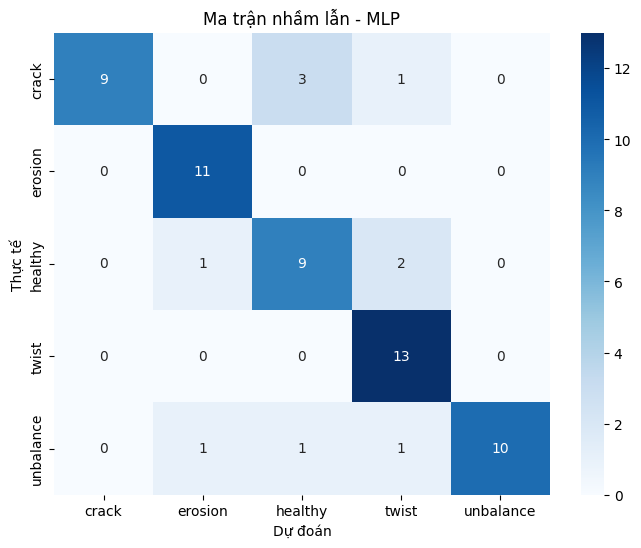

Điểm kiểm tra chéo tốt nhất (MLP): 0.7111
Tham số tốt nhất (MLP): {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
Báo cáo phân loại (MLP):
               precision    recall  f1-score   support

       crack       1.00      0.69      0.82        13
     erosion       0.85      1.00      0.92        11
     healthy       0.69      0.75      0.72        12
       twist       0.76      1.00      0.87        13
   unbalance       1.00      0.77      0.87        13

    accuracy                           0.84        62
   macro avg       0.86      0.84      0.84        62
weighted avg       0.86      0.84      0.84        62

Không thể tính tầm quan trọng đặc trưng cho MLP
Mô hình MLP đã được lưu dưới dạng 'wind_turbine_fault_model_mlp.pkl'

Đang huấn luyện mô hình: SVM
Fitting 5 folds for each of 90 candidates, totalling 450 fits


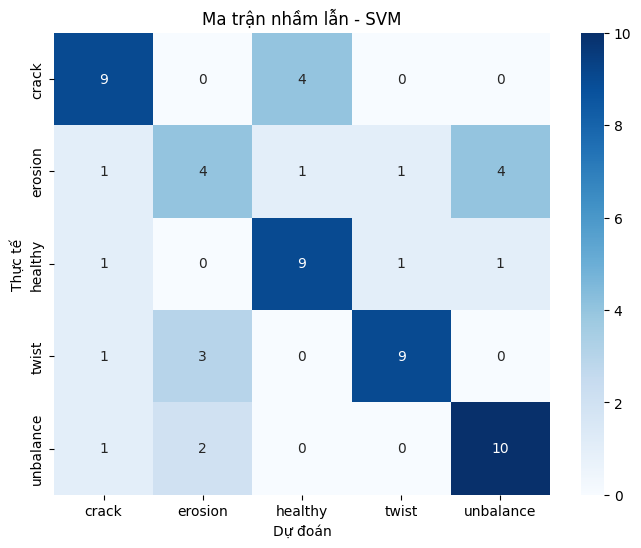

Điểm kiểm tra chéo tốt nhất (SVM): 0.6188
Tham số tốt nhất (SVM): {'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
Báo cáo phân loại (SVM):
               precision    recall  f1-score   support

       crack       0.69      0.69      0.69        13
     erosion       0.44      0.36      0.40        11
     healthy       0.64      0.75      0.69        12
       twist       0.82      0.69      0.75        13
   unbalance       0.67      0.77      0.71        13

    accuracy                           0.66        62
   macro avg       0.65      0.65      0.65        62
weighted avg       0.66      0.66      0.66        62

Không thể tính tầm quan trọng đặc trưng cho SVM
Mô hình SVM đã được lưu dưới dạng 'wind_turbine_fault_model_svm.pkl'
Đã lưu các tham số: scaler_amplitude, scaler, pca, label_encoder.

So sánh hiệu suất các mô hình:
      Model  Cross-Validation Accuracy  Test Accuracy  Macro F1-Score
0  LightGBM                   0.719876       0.903226        0.905157
1       M

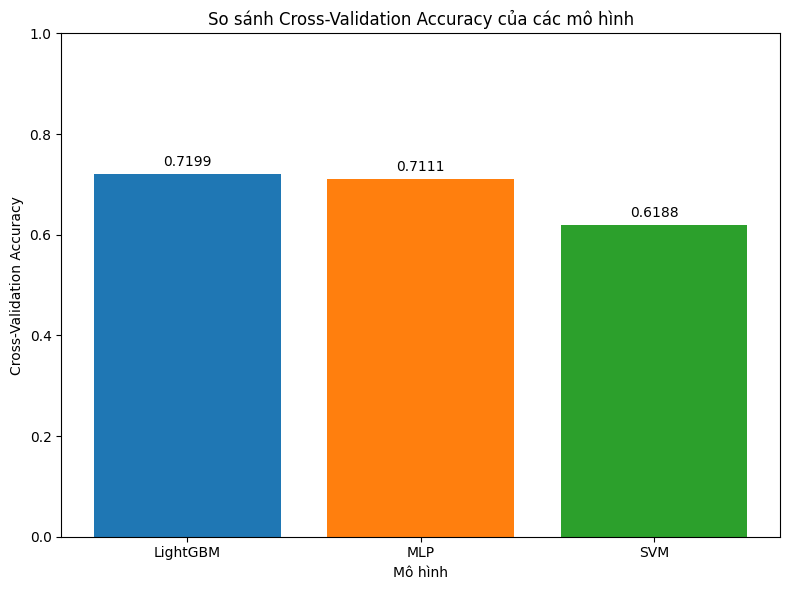

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
import pywt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from scipy.stats import entropy
import zipfile
import tempfile
from collections import defaultdict
import json
import lightgbm as lgb
import re
import warnings

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Tạo thư mục output
output_dir = 'model_outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Hàm lưu tham số
def save_training_params(scaler_amplitude, scaler, pca, label_encoder):
    os.makedirs(output_dir, exist_ok=True)
    joblib.dump(scaler_amplitude, os.path.join(output_dir, 'scaler_amplitude.pkl'))
    joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
    joblib.dump(pca, os.path.join(output_dir, 'pca.pkl'))
    joblib.dump(label_encoder, os.path.join(output_dir, 'label_encoder.pkl'))
    print("Đã lưu các tham số: scaler_amplitude, scaler, pca, label_encoder.")

# (Giữ nguyên phần giải nén file ZIP và đọc dữ liệu từ mã gốc)
zip_file = 'Wind Turbine Blades Fault Diagnosis based on Vibration Dataset Analysis.zip'
config_file = 'file_config.json'
file_config = {
    'H-for-Vw=5.0.csv': {'state': 'healthy', 'wind_speed': 5.0},
    'Crack Fault-Vw=5.csv': {'state': 'crack', 'wind_speed': 5.0},
    'Erosion Fault state-Vw=5.csv': {'state': 'erosion', 'wind_speed': 5.0},
    'unbalance fault state-Vw=5.csv': {'state': 'unbalance', 'wind_speed': 5.0},
    'twist fault when Vw=5.xlsx': {'state': 'twist', 'wind_speed': 5.0},
    'H-for Vw=1.3.csv': {'state': 'healthy', 'wind_speed': 1.3},
    'Crack State-Vw=1.3.csv': {'state': 'crack', 'wind_speed': 1.3},
    'Erosion fault state-Vw=1.3.csv': {'state': 'erosion', 'wind_speed': 1.3},
    'UnbalanceState-Vw=1.3.csv': {'state': 'unbalance', 'wind_speed': 1.3},
    'twist fault when Vw=1.3.xlsx': {'state': 'twist', 'wind_speed': 1.3},
    'H for Vw=2.3.csv': {'state': 'healthy', 'wind_speed': 2.3},
    'unbalance fault state=Vw=2.3.csv': {'state': 'unbalance', 'wind_speed': 2.3},
    'H-for-Vw=3.2.csv': {'state': 'healthy', 'wind_speed': 3.2},
    'twist faultwhenVw=3.2.xlsx': {'state': 'twist', 'wind_speed': 3.2},
    'H-for-Vw=3.7.csv': {'state': 'healthy', 'wind_speed': 3.7},
    'H-for-Vw=4.5.csv': {'state': 'healthy', 'wind_speed': 4.5},
    'crack fault state-Vw=4.5.csv': {'state': 'crack', 'wind_speed': 4.5},
    'H-Vw=5.3.csv': {'state': 'healthy', 'wind_speed': 5.3},
    'Crack Fault-Vw=5.4.csv': {'state': 'crack', 'wind_speed': 5.4},
    'Erosion fault state-Vw=5.3.csv': {'state': 'erosion', 'wind_speed': 5.3},
    'unbalance fault state-Vw=4.7.csv': {'state': 'unbalance', 'wind_speed': 4.7},
    'unbalance fault state-Vw=4.2.csv': {'state': 'unbalance', 'wind_speed': 4.2},
    'Crack state-Vw=2.8.csv': {'state': 'crack', 'wind_speed': 2.8},
    'Erosion fault state-Vw=2.1.csv': {'state': 'erosion', 'wind_speed': 2.1},
    'Erosion fault state-Vw=2.8.csv': {'state': 'erosion', 'wind_speed': 2.8},
    'unbalnce fault state-Vw=3.csv': {'state': 'unbalance', 'wind_speed': 3.0},
    'Erosion Fault State-Vw=4.2.csv': {'state': 'erosion', 'wind_speed': 4.2},
    'unbalance fault state-Vw=3.4.csv': {'state': 'unbalance', 'wind_speed': 3.4},
    'twist fault when Vw=4.7.xlsx': {'state': 'twist', 'wind_speed': 4.7},
    'crack fault-Vw=4.csv': {'state': 'crack', 'wind_speed': 4.0},
    'Crack state-Vw=3.3.csv': {'state': 'crack', 'wind_speed': 3.3},
    'Erosion fault state-Vw=3.4.csv': {'state': 'erosion', 'wind_speed': 3.4},
    'twist fault when Vwind=4.xlsx': {'state': 'twist', 'wind_speed': 4.0},
    'twsist faut when Vw=2.xlsx': {'state': 'twist', 'wind_speed': 2.0},
    'twist fault when Vw=5.3.xlsx': {'state': 'twist', 'wind_speed': 5.3},
    'H-for-Vw=5.csv': {'state': 'healthy', 'wind_speed': 5.0}
}

if not os.path.exists(config_file):
    with open(config_file, 'w') as f:
        json.dump(file_config, f, indent=4)

with tempfile.TemporaryDirectory() as temp_dir:
    print(f"Giải nén file ZIP vào thư mục tạm: {temp_dir}")
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            print("Nội dung file ZIP:")
            for file in zip_ref.namelist():
                print(file)
            zip_ref.extractall(temp_dir)
    except zipfile.BadZipFile:
        raise ValueError(f"Lỗi: {zip_file} không phải là file ZIP hợp lệ hoặc bị hỏng")

    def find_data_files(directory):
        data_files = []
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.csv') or file.endswith('.xlsx'):
                    data_files.append(os.path.join(root, file))
        return data_files

    data_files = find_data_files(temp_dir)
    if not data_files:
        raise FileNotFoundError("Không tìm thấy file CSV hoặc XLSX trong file ZIP đã giải nén")

    try:
        with open(config_file, 'r') as f:
            file_config = json.load(f)
    except FileNotFoundError:
        print(f"Không tìm thấy {config_file}. Sử dụng cấu hình mặc định.")

    dataset = []
    for data_file in data_files:
        file = os.path.basename(data_file)
        print(f"Xử lý file: {file}")
        try:
            if file.endswith('.csv'):
                df = pd.read_csv(data_file, sep=';|,', engine='python')
            elif file.endswith('.xlsx'):
                df = pd.read_excel(data_file)
        except Exception as e:
            print(f"Lỗi khi đọc file {file}: {e}")
            continue

        print(f"Các cột trong {file}: {df.columns}")

        config_entry = file_config.get(file, None)
        if config_entry is None:
            print(f"File {file} không có trong file cấu hình. Bỏ qua.")
            continue

        state = config_entry['state']
        wind_speed = config_entry['wind_speed']

        column_map = {
            'Time - Voltage_1;Amplitude - Voltage_1': 'amplitude',
            'Time - sec;Amplitude - g': 'amplitude',
            'Amplitude - Voltage_1': 'amplitude',
            'Time - Voltage_1': 'time',
            'Time - sec': 'time'
        }
        df = df.rename(columns=column_map)

        if 'amplitude' not in df.columns:
            for col in df.columns:
                if 'Amplitude' in col:
                    df['amplitude'] = df[col]
                elif ';' in str(df[col].iloc[0]):
                    df['amplitude'] = df[col].apply(lambda x: float(x.split(';')[-1]) if isinstance(x, str) else float(x))
                    df['time'] = df[col].apply(lambda x: float(x.split(';')[0]) if isinstance(x, str) else np.nan)
                    break

        if 'amplitude' not in df.columns:
            print(f"Không tìm thấy cột amplitude trong {file}")
            continue

        if 'time' not in df.columns:
            df['time'] = np.arange(len(df)) / 1000.0

        df['state'] = state
        df['wind_speed'] = wind_speed
        dataset.append(df)

if not dataset:
    raise ValueError("Không có file nào được xử lý thành công. Kiểm tra file cấu hình và dữ liệu.")

full_data = pd.concat(dataset, ignore_index=True)

# Tiền xử lý dữ liệu
print("Các cột trong full_data:", full_data.columns)
print("Giá trị thiếu:\n", full_data.isna().sum())
print("Kiểm tra giá trị bất thường trong amplitude:")
print(full_data['amplitude'].describe())
print("Số giá trị NaN hoặc Inf:", full_data['amplitude'].isna().sum() + np.isinf(full_data['amplitude']).sum())
full_data = full_data.dropna(subset=['amplitude'])
scaler_amplitude = StandardScaler()
full_data['amplitude_scaled'] = scaler_amplitude.fit_transform(full_data[['amplitude']])

# Trích xuất đặc trưng
def extract_features(signal, fs=1000):
    if isinstance(signal, pd.Series):
        signal = signal.to_numpy()
    elif not isinstance(signal, np.ndarray):
        signal = np.array(signal)

    features = {
        'mean': signal.mean(),
        'std': signal.std(),
        'peak': np.abs(signal).max(),
        'rms': ((signal ** 2).mean()) ** 0.5,
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurt(),
        'crest_factor': np.abs(signal).max() / (((signal ** 2).mean()) ** 0.5) if ((signal ** 2).mean()) > 0 else 0,
        'signal_entropy': entropy(np.histogram(signal, bins=10, density=True)[0]) if np.sum(signal) > 0 else 0,
        'zero_crossing_rate': ((signal[:-1] * signal[1:] < 0).sum()) / len(signal)
    }
    fft_vals = np.abs(fft(signal))[:len(signal) // 2]
    freqs = np.linspace(0, fs / 2, len(fft_vals))
    low_freq = fft_vals[(freqs <= 50)]
    mid_freq = fft_vals[(freqs > 50) & (freqs <= 200)]
    high_freq = fft_vals[(freqs > 200) & (freqs <= 500)]
    features['low_freq_energy'] = np.log1p(np.sum(low_freq ** 2)) if len(low_freq) > 0 else 0
    features['mid_freq_energy'] = np.log1p(np.sum(mid_freq ** 2)) if len(mid_freq) > 0 else 0
    features['high_freq_energy'] = np.log1p(np.sum(high_freq ** 2)) if len(low_freq) > 0 else 0
    coeffs = pywt.wavedec(signal, 'db4', level=2)
    features['wavelet_energy'] = sum(np.sum(c ** 2) for c in coeffs)
    features['wavelet_std'] = np.std(coeffs[-1])
    features['approx_energy'] = np.sum(coeffs[0] ** 2)
    features['detail_energy_1'] = np.sum(coeffs[1] ** 2)
    features['detail_energy_2'] = np.sum(coeffs[2] ** 2)
    return features

def augment_signal(signal, noise_factor=0.02, shift_max=5, scale_factor_range=(0.9, 1.1)):
    noise = np.random.normal(0, noise_factor, len(signal))
    noisy_signal = signal + noise
    shift = np.random.randint(-shift_max, shift_max)
    shifted_signal = np.roll(signal, shift)
    scale_factor = np.random.uniform(scale_factor_range[0], scale_factor_range[1])
    scaled_signal = signal * scale_factor
    return noisy_signal, shifted_signal, scaled_signal

def determine_segment_length(group_sizes):
    min_samples = min(group_sizes)
    if min_samples < 10:
        raise ValueError("Nhóm nhỏ nhất có ít hơn 10 mẫu, không đủ để trích xuất đặc trưng.")
    elif min_samples < 100:
        return 50
    elif min_samples < 200:
        return 100
    else:
        return 200

features_list = []
group_sizes = [len(group) for _, group in full_data.groupby(['state', 'wind_speed'])]
segment_length = determine_segment_length(group_sizes)
print(f"Đã chọn segment_length={segment_length} dựa trên kích thước nhóm.")

for (state, wind_speed), group in full_data.groupby(['state', 'wind_speed']):
    print(f"Nhóm {state}, wind_speed={wind_speed}: {len(group)} mẫu")
    for i in range(0, len(group), segment_length):
        segment = group['amplitude'].iloc[i:i + segment_length]
        if len(segment) >= 10:
            if len(segment) < segment_length:
                segment = np.pad(segment, (0, segment_length - len(segment)), mode='constant')
            features = extract_features(segment)
            features['state'] = state
            features['wind_speed'] = wind_speed
            features_list.append(features)
            noisy_segment, shifted_signal, scaled_segment = augment_signal(segment, noise_factor=0.02, shift_max=5)
            for aug_segment in [noisy_segment, shifted_signal, scaled_segment]:
                features = extract_features(aug_segment)
                features['state'] = state
                features['wind_speed'] = wind_speed
                features_list.append(features)
        else:
            print(
                f"Bỏ qua đoạn trong nhóm {state}, wind_speed={wind_speed}: chỉ có {len(segment)} mẫu, cần ít nhất 10")

features_df = pd.DataFrame(features_list)
print("Số mẫu trong features_df:", len(features_df))
if features_df.empty:
    raise ValueError("Không tạo được đặc trưng nào. Kiểm tra segment_length và số mẫu mỗi nhóm.")
print("Phân bố lớp:\n", features_df['state'].value_counts())

# Biểu đồ
plt.figure(figsize=(8, 6))
features_df['state'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Trạng thái')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bố lớp trong tập dữ liệu')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'class_distribution.png'))
plt.show()

key_features = ['mean', 'std', 'peak', 'wavelet_energy']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='state', y=feature, data=features_df)
    plt.title(f'Phân bố {feature} theo trạng thái')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_boxplots.png'))
plt.show()

plt.figure(figsize=(12, 10))
corr_matrix = features_df.drop(['state', 'wind_speed'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Ma trận tương quan của các đặc trưng trước PCA')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_matrix_pre_pca.png'))
plt.show()

# Áp dụng PCA
X = features_df.drop(['state', 'wind_speed'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_components = min(8, X_scaled.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
print(f"Đã giảm chiều từ {X_scaled.shape[1]} xuống {X_pca.shape[1]} đặc trưng với PCA.")
print(f"Tỷ lệ phương sai được giải thích: {sum(pca.explained_variance_ratio_):.4f}")

pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
features_df_pca = pd.DataFrame(X_pca, columns=pca_columns)
features_df_pca['state'] = features_df['state']
features_df_pca['wind_speed'] = features_df['wind_speed']

plt.figure(figsize=(8, 6))
corr_matrix_pca = features_df_pca.drop(['state', 'wind_speed'], axis=1).corr()
sns.heatmap(corr_matrix_pca, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Ma trận tương quan của các thành phần PCA')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_matrix_post_pca.png'))
plt.show()

plt.figure(figsize=(10, 8))
for state in features_df_pca['state'].unique():
    subset = features_df_pca[features_df_pca['state'] == state]
    plt.scatter(subset['PC1'], subset['PC2'], label=state, alpha=0.6)
plt.xlabel('Thành phần chính 1 (PC1)')
plt.ylabel('Thành phần chính 2 (PC2)')
plt.title('Phân tán PCA của dữ liệu theo trạng thái')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_scatter.png'))
plt.show()

wind_speeds = [1.3, 5.0]
for ws in wind_speeds:
    plt.figure(figsize=(10, 6))
    for state, group in full_data[full_data['wind_speed'] == ws].groupby('state'):
        plt.plot(group['time'][:500], group['amplitude'][:500], label=state)
    plt.xlabel('Thời gian (s)')
    plt.ylabel('Biên độ (g)')
    plt.title(f'Tín hiệu dao động tại tốc độ gió {ws} m/s')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'vibration_signals_ws_{ws}.png'))
    plt.show()

# Hàm đánh giá mô hình
def evaluate_all_models(X, y, model_configs, cv=5, test_size=0.15, random_state=42):
    results = defaultdict(dict)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    for model_name, config in model_configs.items():
        print(f"\nĐang huấn luyện mô hình: {model_name}")
        model = config['model']
        param_grid = config['param_grid']

        grid_search = GridSearchCV(
            model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train, y_train_encoded)

        results[model_name]['best_score'] = grid_search.best_score_
        results[model_name]['best_params'] = grid_search.best_params_
        results[model_name]['best_model'] = grid_search.best_estimator_

        y_pred = grid_search.best_estimator_.predict(X_test)
        report = classification_report(
            y_test_encoded, y_pred, target_names=le.classes_, zero_division=0, output_dict=True
        )
        results[model_name]['classification_report'] = report

        cm = confusion_matrix(y_test_encoded, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'Ma trận nhầm lẫn - {model_name}')
        plt.xlabel('Dự đoán')
        plt.ylabel('Thực tế')
        plt.savefig(os.path.join(output_dir, f'confusion_matrix_{model_name.lower()}.png'))
        plt.show()

        if hasattr(grid_search.best_estimator_, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': grid_search.best_estimator_.feature_importances_
            }).sort_values(by='importance', ascending=False)
            results[model_name]['feature_importance'] = feature_importance
        else:
            results[model_name]['feature_importance'] = None

        print(f"Điểm kiểm tra chéo tốt nhất ({model_name}): {grid_search.best_score_:.4f}")
        print(f"Tham số tốt nhất ({model_name}): {grid_search.best_params_}")
        print(f"Báo cáo phân loại ({model_name}):\n", classification_report(
            y_test_encoded, y_pred, target_names=le.classes_, zero_division=0
        ))
        if results[model_name]['feature_importance'] is not None:
            print(f"Tầm quan trọng đặc trưng ({model_name}):\n", results[model_name]['feature_importance'])
        else:
            print(f"Không thể tính tầm quan trọng đặc trưng cho {model_name}")

        joblib.dump(grid_search.best_estimator_, os.path.join(output_dir, f'wind_turbine_fault_model_{model_name.lower()}.pkl'))
        print(f"Mô hình {model_name} đã được lưu dưới dạng 'wind_turbine_fault_model_{model_name.lower()}.pkl'")

    return results, le, X_test, y_test

# Cấu hình mô hình
model_configs = {
    'LightGBM': {
        'model': lgb.LGBMClassifier(
            random_state=42,
            class_weight='balanced',
            force_col_wise=True,
            verbose=-1,
            min_child_samples=5,
            min_split_gain=0.0
        ),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 7, 10],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [15, 31, 50],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    },
    'MLP': {
        'model': MLPClassifier(random_state=42, max_iter=1000),
        'param_grid': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'learning_rate_init': [0.001, 0.01],
            'alpha': [0.0001, 0.001]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, class_weight='balanced'),
        'param_grid': {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear', 'poly'],
            'gamma': [0.01, 0.1, 'scale'],
            'degree': [2, 3]
        }
    }
}

# Đánh giá mô hình với dữ liệu PCA
X_pca = features_df_pca.drop(['state', 'wind_speed'], axis=1)
y = features_df_pca['state']
results, label_encoder, X_test, y_test = evaluate_all_models(X_pca, y, model_configs)

# Lưu các tham số
save_training_params(scaler_amplitude, scaler, pca, label_encoder)

# So sánh hiệu suất
print("\nSo sánh hiệu suất các mô hình:")
comparison = pd.DataFrame({
    'Model': [],
    'Cross-Validation Accuracy': [],
    'Test Accuracy': [],
    'Macro F1-Score': []
})
for model_name, result in results.items():
    comparison = pd.concat([comparison, pd.DataFrame({
        'Model': [model_name],
        'Cross-Validation Accuracy': [result['best_score']],
        'Test Accuracy': [result['classification_report']['accuracy']],
        'Macro F1-Score': [result['classification_report']['macro avg']['f1-score']]
    })], ignore_index=True)

comparison = comparison.sort_values(by='Test Accuracy', ascending=False)
print(comparison)
comparison.to_csv(os.path.join(output_dir, 'model_comparison.csv'), index=False)

plt.figure(figsize=(8, 6))
plt.bar(comparison['Model'], comparison['Cross-Validation Accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xlabel('Mô hình')
plt.ylabel('Cross-Validation Accuracy')
plt.title('So sánh Cross-Validation Accuracy của các mô hình')
plt.ylim(0, 1)
for i, v in enumerate(comparison['Cross-Validation Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cross_validation_accuracy.png'))
plt.show()

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
import pywt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import joblib
from scipy.stats import entropy
import os
from collections import Counter
import warnings

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Thư mục chứa mô hình và tham số đã lưu
output_dir = 'model_outputs'

# Hàm trích xuất đặc trưng (giữ nguyên từ mã gốc)
def extract_features(signal, fs=1000):
    if isinstance(signal, pd.Series):
        signal = signal.to_numpy()
    elif not isinstance(signal, np.ndarray):
        signal = np.array(signal)

    features = {
        'mean': signal.mean(),
        'std': signal.std(),
        'peak': np.abs(signal).max(),
        'rms': ((signal ** 2).mean()) ** 0.5,
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurt(),
        'crest_factor': np.abs(signal).max() / (((signal ** 2).mean()) ** 0.5) if ((signal ** 2).mean()) > 0 else 0,
        'signal_entropy': entropy(np.histogram(signal, bins=10, density=True)[0]) if np.sum(signal) > 0 else 0,
        'zero_crossing_rate': ((signal[:-1] * signal[1:] < 0).sum()) / len(signal)
    }
    fft_vals = np.abs(fft(signal))[:len(signal) // 2]
    freqs = np.linspace(0, fs / 2, len(fft_vals))
    low_freq = fft_vals[(freqs <= 50)]
    mid_freq = fft_vals[(freqs > 50) & (freqs <= 200)]
    high_freq = fft_vals[(freqs > 200) & (freqs <= 500)]
    features['low_freq_energy'] = np.log1p(np.sum(low_freq ** 2)) if len(low_freq) > 0 else 0
    features['mid_freq_energy'] = np.log1p(np.sum(mid_freq ** 2)) if len(mid_freq) > 0 else 0
    features['high_freq_energy'] = np.log1p(np.sum(high_freq ** 2)) if len(low_freq) > 0 else 0
    coeffs = pywt.wavedec(signal, 'db4', level=2)
    features['wavelet_energy'] = sum(np.sum(c ** 2) for c in coeffs)
    features['wavelet_std'] = np.std(coeffs[-1])
    features['approx_energy'] = np.sum(coeffs[0] ** 2)
    features['detail_energy_1'] = np.sum(coeffs[1] ** 2)
    features['detail_energy_2'] = np.sum(coeffs[2] ** 2)
    return features

# Hàm xử lý và dự đoán
def predict_fault(signal=None, csv_file=None, segment_length=200):
    # Kiểm tra input
    if signal is None and csv_file is None:
        # Tạo tín hiệu ngẫu nhiên nếu không có input
        signal = np.random.normal(0, 1, segment_length)
        print("Không có tín hiệu hoặc file CSV được cung cấp. Tạo tín hiệu ngẫu nhiên.")

    # Tải các tham số và mô hình đã lưu
    try:
        scaler = joblib.load(os.path.join(output_dir, 'scaler.pkl'))
        pca = joblib.load(os.path.join(output_dir, 'pca.pkl'))
        label_encoder = joblib.load(os.path.join(output_dir, 'label_encoder.pkl'))
        models = {
            'LightGBM': joblib.load(os.path.join(output_dir, 'wind_turbine_fault_model_lightgbm.pkl')),
            'MLP': joblib.load(os.path.join(output_dir, 'wind_turbine_fault_model_mlp.pkl')),
            'SVM': joblib.load(os.path.join(output_dir, 'wind_turbine_fault_model_svm.pkl'))
        }
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Không tìm thấy file mô hình hoặc tham số: {e}. Vui lòng chạy mã huấn luyện trước.")

    # Xử lý dữ liệu đầu vào
    if csv_file:
        try:
            df = pd.read_csv(csv_file, sep=';|,', engine='python')
            if 'amplitude' not in df.columns:
                for col in df.columns:
                    if 'Amplitude' in col or 'amplitude' in col.lower():
                        df['amplitude'] = df[col]
                        break
                    elif ';' in str(df[col].iloc[0]):
                        df['amplitude'] = df[col].apply(lambda x: float(x.split(';')[-1]) if isinstance(x, str) else float(x))
                        break
            if 'amplitude' not in df.columns:
                raise ValueError("File CSV không chứa cột 'amplitude'.")
            signal = df['amplitude'].to_numpy()
        except Exception as e:
            raise ValueError(f"Lỗi khi đọc file CSV: {e}")

    # Chuyển tín hiệu thành numpy array
    signal = np.array(signal, dtype=float)
    if len(signal) < 10:
        raise ValueError("Tín hiệu quá ngắn, cần ít nhất 10 mẫu.")

    # Vẽ biểu đồ tín hiệu đầu vào
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(signal)) / 1000, signal)
    plt.xlabel('Thời gian (s)')
    plt.ylabel('Biên độ (g)')
    plt.title('Tín hiệu rung động đầu vào')
    plt.savefig(os.path.join(output_dir, 'input_signal.png'))
    plt.show()

    # Chia tín hiệu thành các đoạn
    segments = []
    if len(signal) < segment_length:
        # Đệm tín hiệu ngắn bằng 0
        signal = np.pad(signal, (0, segment_length - len(signal)), mode='constant')
        segments.append(signal)
    else:
        for i in range(0, len(signal), segment_length):
            segment = signal[i:i + segment_length]
            if len(segment) >= 10:
                if len(segment) < segment_length:
                    segment = np.pad(segment, (0, segment_length - len(segment)), mode='constant')
                segments.append(segment)

    if not segments:
        raise ValueError("Không tạo được đoạn tín hiệu nào hợp lệ.")

    # Trích xuất đặc trưng
    features_list = []
    for segment in segments:
        features = extract_features(segment)
        features_list.append(features)

    features_df = pd.DataFrame(features_list)

    # Chuẩn hóa và giảm chiều
    X_scaled = scaler.transform(features_df)
    X_pca = pca.transform(X_scaled)

    # Dự đoán
    predictions = {}
    all_labels = []
    for model_name, model in models.items():
        y_pred = model.predict(X_pca)
        y_pred_labels = label_encoder.inverse_transform(y_pred)
        all_labels.extend(y_pred_labels)

        try:
            y_proba = model.predict_proba(X_pca)
            proba_dict = {label: proba for label, proba in zip(label_encoder.classes_, y_proba[0])}
        except AttributeError:
            proba_dict = None

        predictions[model_name] = {
            'labels': y_pred_labels,
            'probabilities': proba_dict
        }

    # Kết hợp dự đoán bằng voting
    vote_counts = Counter(all_labels)
    ensemble_label = vote_counts.most_common(1)[0][0]
    predictions['Ensemble'] = {'labels': [ensemble_label], 'probabilities': None}

    return predictions

# Hàm hiển thị kết quả
def display_predictions(predictions):
    print("\nKết quả dự đoán lỗi cánh tuabin gió:")
    for model_name, pred in predictions.items():
        print(f"\nMô hình {model_name}:")
        print(f"Loại lỗi dự đoán: {pred['labels'][0]}")
        if pred['probabilities']:
            print("Xác suất cho từng lớp:")
            for label, proba in pred['probabilities'].items():
                print(f"  {label}: {proba:.4f}")

# Lưu các tham số cần thiết từ mã huấn luyện
def save_training_params(scaler, pca, label_encoder):
    joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
    joblib.dump(pca, os.path.join(output_dir, 'pca.pkl'))
    joblib.dump(label_encoder, os.path.join(output_dir, 'label_encoder.pkl'))
    print("Đã lưu các tham số: scaler, pca, label_encoder.")



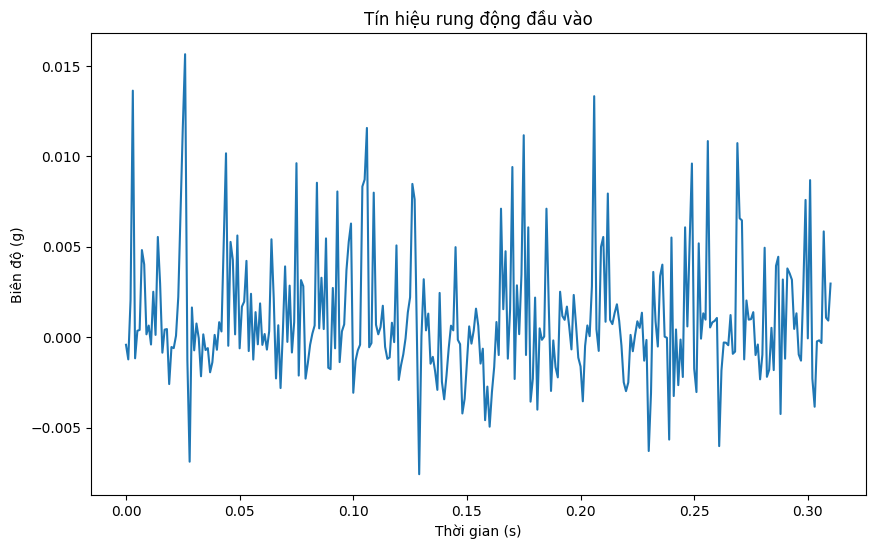


Kết quả dự đoán lỗi cánh tuabin gió:

Mô hình LightGBM:
Loại lỗi dự đoán: healthy
Xác suất cho từng lớp:
  crack: 0.0005
  erosion: 0.0000
  healthy: 0.9995
  twist: 0.0000
  unbalance: 0.0000

Mô hình MLP:
Loại lỗi dự đoán: healthy
Xác suất cho từng lớp:
  crack: 0.0000
  erosion: 0.0000
  healthy: 1.0000
  twist: 0.0000
  unbalance: 0.0000

Mô hình SVM:
Loại lỗi dự đoán: healthy

Mô hình Ensemble:
Loại lỗi dự đoán: healthy


In [32]:
# Ví dụ sử dụng
if __name__ == "__main__":
    # Ví dụ 1: Nhập danh sách số liệu
    sample_signal = [
    -0.000415, -0.001222, 0.002066, 0.013634, -0.001162, 0.000359, 0.000407, 0.004821, 0.004032,
    0.000165, 0.000649, -0.000399, 0.002518, 0.000132, 0.005546, 0.002985, -0.000851, 0.000423,
    0.000455, -0.002586, -0.00054, -0.0006, 8.66e-05, 0.002228, 0.006884, 0.011636, 0.015648,
    -0.001282, -0.006878, 0.001648, -0.000721, 0.000761, -4.41e-05, -0.002155, 0.000162, -0.000705,
    -0.0006, -0.001934, -0.001382, 0.000132, -0.00069, 0.000834, 0.000323, 0.005176, 0.01017,
    -0.000469, 0.005273, 0.004274, 0.000161, 0.005627, -0.00061, 0.001696, 0.00197, 0.004225,
    -0.000761, 0.002405, -0.001232, 0.00139, -0.000389, 0.001873, -0.00042, 0.000182, -0.00068,
    0.000343, 0.005418, 0.002163, -0.002275, 0.000665, -0.002807, 0.000246, 0.003919, -0.000254,
    0.002856, -0.000841, 0.000844, 0.009623, -0.002115, 0.003162, 0.002824, -0.002285, -0.001433,
    -0.00042, 0.000202, 0.000653, 0.008543, 0.000493, 0.003291, 0.000455, 0.005466, -0.001683,
    -0.001764, 0.002727, -0.00061, 0.00806, -0.001372, 0.000326, 0.000714, 0.00371, 0.005273,
    0.006288, -0.003067, -0.001292, -0.000721, -0.00041, 0.008334, 0.00872, 0.011572, -0.00055,
    -0.000318, 0.007995, 0.000694, 0.000165, 0.000563, 0.001744, -0.00053, -0.001192, -0.001112,
    0.000804, -0.000269, 0.005079, -0.002355, -0.001553, -0.000946, -5.86e-05, 0.001374, 0.002211,
    0.008479, 0.007625, -0.000129, -0.00757, 6.18e-05, 0.00321, 0.000383, 0.001309, -0.001463,
    -0.001082, -0.001874, -0.002907, 0.002453, -0.002466, -0.003428, -0.002135, -0.00059, 0.000643,
    0.000383, 0.004983, -0.000139, -0.000382, -0.004211, -0.003398, -0.001392, 0.000603, -0.00035,
    0.000375, 0.001583, 0.000633, -0.001453, -0.00063, -0.004582, -0.002726, -0.004943, -0.003037,
    -0.001643, 0.000844, -0.000981, 0.007109, 0.001551, 0.004757, -0.001182, 0.001551, 0.009413,
    -0.002305, 0.002872, 0.000172, 0.003468, 0.011169, -0.000979, 0.006078, -0.003559, -0.002295,
    0.002195, -0.004, 0.000493, -0.000139, 4.17e-05, 0.007109, 0.001825, -0.002967, -0.000173,
    -0.001653, -0.002215, 0.002518, 0.00118, 0.000964, 0.001696, 0.0006, -0.00067, 0.00234,
    0.000713, -0.001122, -0.001613, -0.003539, -0.00048, 0.000653, 6.18e-05, 0.002824, 0.013328,
    0.000443, -0.000753, 0.004999, 0.005546, 0.000858, 0.007947, 0.000964, 0.000729, 0.001341,
    0.001825, 0.000904, -0.00046, -0.002486, -0.002977, -0.002496, 0.000132, -0.000771, 0.000132,
    0.000884, 0.00052, 0.001358, -0.001292, -0.000147, -0.006287, -0.003087, 0.003613, 0.000884,
    -0.000511, 0.003388, 0.004016, 3.65e-05, -2.85e-05, -0.005655, 0.005514, -0.003248, 0.000433,
    -0.002646, -0.000125, -0.002195, 0.006078, 0.0006, 0.00524, 0.009606, -0.001733, -0.003027,
    0.005192, -7.63e-05, 0.001325, 0.000975, 0.010847, 0.000543, 0.000826, 0.000906, 0.001068,
    -0.006016, -0.001834, -0.000289, -0.000299, -0.00044, 0.001229, -0.000914, -0.000791, 0.010734,
    0.006578, 0.006465, -0.001222, 0.002034, 0.000975, 0.001003, 0.00139, -0.000981, -0.0004,
    -0.002325, -0.000962, 0.00495, -0.002185, -0.001794, 0.000523, -0.001814, 0.003951, 0.004451,
    -0.004241, 0.003194, -0.001182, 0.003806, 0.003533, 0.003178, 0.000463, 0.001325, -0.000952,
    -0.001292, 0.00263, 0.007593, -6.02e-05, 0.008688, -0.002285, -0.00384, -0.000228, -0.000169,
    -0.000318, 0.005853, 0.001084, 0.000924, 0.002969
]
    try:
        predictions = predict_fault(signal=sample_signal)
        display_predictions(predictions)
    except Exception as e:
        print(f"Lỗi khi dự đoán: {e}")

    # Ví dụ 2: Nhập từ file CSV
    # csv_file = "your_signal.csv"
    # try:
    #     predictions = predict_fault(csv_file=csv_file)
    #     display_predictions(predictions)
    # except Exception as e:
    #     print(f"Lỗi khi dự đoán: {e}")